# 6. GLMの応用範囲をひろげる

(ざっくり要約)

* GLMを使えば二項分布やロジットリンク関数によるロジスティック回帰も可能である．
    * 方法は触れないが，正規分布およびガンマ分布のGLMも可能
* 交互作用項はむやみに入れるべきではない．
    * そもそも解釈が不可能なほどややこしくなる場合がある．
    * 「個体差」「場所差」によるばらつきを考慮しないGLMでは，交互作用項の効果を課題推定してしまう場合がある．
    * この場合一見AICが最良になるので複雑なモデルを採用してしまいがちである．
* 割り算値の統計モデルはやめたほうが良い．
    * 例えば $\log(x + 1)$ は本当に正規分布しているのか?
* オフセット項 (メモ: 係数をつけないパラメータ．行毎に異なる定数項) を使おう．
    * 例えば対数リンク関数の場合，オフセット項を足すことで割り算値を表現できる．

※ rpy2.ipythonの設定が面倒な人はRのコードブロックをR側で実行してください．

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
d = pd.read_csv('data4a.csv')

In [3]:
d.describe(include='all')

,N,y,x,f
count,100.0,100.000000,100.000000,100
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,C
freq,NaN,NaN,NaN,50
mean,8.0,5.080000,9.967200,NaN
std,0.0,2.743882,1.088954,NaN
min,8.0,0.000000,7.660000,NaN
25%,8.0,3.000000,9.337500,NaN
50%,8.0,6.000000,9.965000,NaN
75%,8.0,8.000000,10.770000,NaN


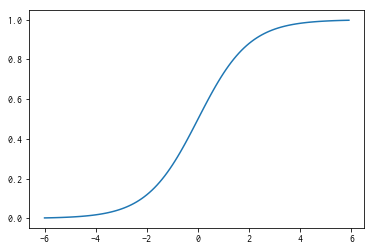

In [4]:
def logistic(z):
    return 1 / (1 + np.exp(-z))


z = np.arange(-6, 6, 0.1)
plt.plot(z, logistic(z))

## 二項分布を用いたGLM

In [5]:
d['y1'] = d['y']  # survived
d['y2'] = d['N'] - d['y']  # died
fit = smf.glm('y1 + y2 ~ x + f', data=d, family=sm.families.Binomial()).fit()

In [6]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                   土, 25  2 2017   Deviance:                       123.03
Time:                        20:48:06   Pearson chi2:                     13.7
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

stepAICに対応する関数は2017年現在で存在しないが，forward selectionの仕組み自体はシンプルなので，自作するのも容易

In [7]:
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can use either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """

    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    remaining = set(exog)
    selected = []  # 採用が確定された要因

    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    aic = model(formula=formula, **kwargs).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [candidate])
            formula = formula_head + formula_tail
            aic = model(formula=formula, **kwargs).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    return model(formula, **kwargs).fit()

In [8]:
step_aic(smf.glm, ['x', 'f'], ['y1', 'y2'], data=d, family=sm.families.Binomial())

AIC: 644.409, formula: y1 + y2 ~ 1
AIC: 364.345, formula: y1 + y2 ~ x
AIC: 637.76, formula: y1 + y2 ~ f
AIC: 272.211, formula: y1 + y2 ~ x + f
The best formula: y1 + y2 ~ x + f


In [9]:
fit = smf.glm('y1 + y2 ~ x * f', data=d, family=sm.families.Binomial()).fit()

In [10]:
fit.summary()  # 交互作用項が追加された

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -132.81
Date:                   土, 25  2 2017   Deviance:                       122.43
Time:                        20:48:06   Pearson chi2:                     13.6
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.5233      1.886     -9.821      0.000     -22.220     -14.827
f[T.T]        -0.0638      2.704     -0.024      0.981      -5.363       5.235
x              1.8525      0.186      9.983      0.000       1.489       2.216
x:f[T.T]       0.2163      0.280      0.772      0.440      -0.333       0.765
==============================================================================
"""

In [11]:
d = pd.read_csv('data4b.csv')

In [12]:
fit = smf.glm('y ~ x', offset=np.log(d['A']), data=d, family=sm.families.Poisson()).fit()
fit.summary()  # 教科書には答えはありませんが，Rの出力と一致しています．

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -323.17
Date:                   土, 25  2 2017   Deviance:                       81.608
Time:                        20:48:06   Pearson chi2:                     81.5
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9731      0.045     21.600      0.000       0.885       1.061
x              1.0383      0.078     13.364      0.000       0.886       1.191
==============================================================================
"""

## 正規分布
ポワソン分布の時はstats.norm.pmfだったが，正規分布は離散値なのでstats.norm.pdf (probability density function) を用いる．スペルの違いに注意．

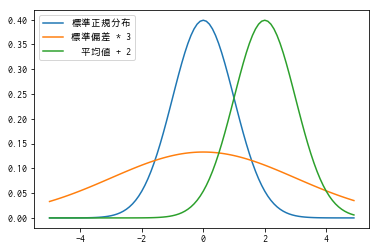

In [13]:
y = np.arange(-5, 5, 0.1)
plt.plot(y, stats.norm.pdf(y, loc=0, scale=1),
         label='標準正規分布')
plt.plot(y, stats.norm.pdf(y, loc=0, scale=3),
         label='標準偏差 * 3')
plt.plot(y, stats.norm.pdf(y, loc=2, scale=1),
         label='  平均値 + 2')
plt.legend()

In [14]:
stats.norm.cdf(1.8, 0, 1) - stats.norm.cdf(1.2, 0, 1)

0.079139351108782452

In [15]:
stats.norm.pdf(1.5, 0, 1) * 0.6

0.077710557399535043

## ガンマ分布

In [16]:
%%R
load('d.RData')
write.table(d, file='data4c.csv', sep=',', row.names=F)

In [17]:
d = pd.read_csv('data4c.csv')
d.head()

,x,y
0,0.001000,0.000887
1,0.017306,0.023465
2,0.033612,0.069876
3,0.049918,0.034340
4,0.066224,0.026520


In [18]:
d['logx'] = np.log(d['x'])
fit = smf.glm('y ~ logx', data=d, family=sm.families.Gamma(link=sm.families.links.log)).fit()
fit.summary()  # 教科書には答えはありませんが，Rの出力と一致しています．

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.325084320549
Method:                          IRLS   Log-Likelihood:                 58.471
Date:                   土, 25  2 2017   Deviance:                       17.251
Time:                        20:48:07   Pearson chi2:                     15.6
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0403      0.119     -8.759      0.000      -1.273      -0.808
logx           0.6832      0.068      9.992      0.000       0.549       0.817
==============================================================================
"""